### Pre-load modules

In [1]:
############# INITIALISING #############
##### Plotting
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.size'] = 12
#### General modules
import numpy as np # It's numpy. Duh.
import time # for time.time() timing methods
from pprint import pprint # nice output
import pandas as pd # Our 'interface with R dataframes' tool
from pandas.plotting import autocorrelation_plot # Autocorr plot
import matplotlib.pyplot as plt # plotting
from scipy.optimize import curve_fit # to fit the GK soln

#### Interactivity
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


#### Big bag of ML
from sklearn import base
from sklearn import pipeline
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


.
.

.
.

.
.
#  JONATHAN BURLEY
## DATA INCUBATOR CAPSTONE
.
.

.
.

.
.

**Introduction**

This Capstone project implements a novel method of predicting an output timeseries from an input timeseries. The novel method accurately predicts outputs that are very poorly correlated to the input by making use of the limited number of ways that sensibly interacting systems can affect one another.  I call this method '_Kernel Convolution_': using a kernel function to map inputs to outputs according to the laws constraining the Kernel's shape. 

The standard method for dealing with paried input:output timeseries in machine learning is a lagged linear model. Such models take the input timeseries and repeatedly shift it in time (thus creating a set of lagged timeseries), and then try to find a way to add all these lagged timeseries together to best approximate the output timeseries.

The lagged linear method sounds like a lot of work (because it is), however the method is prevented from becoming untenable because its mathematically intense step of "find the best way to add everything" is formulated as a matrix linear algebra problem and can make use of the well-known computational optimisations.  However, matrix algebra does not fix the fact that exploring all possible options is a recipe for overfitting, that it wastes CPU time to explore a large space instead of a small one, and wastes memory storing many lagged repetitions of a timeseries.

Why did I tell you all that?  Well, frank description of the lagged linear method highlights the ways that we can make efficiencies. We don't want to consider every solution, we want to consider sensible solutions. By limiting ourselves to sensible solutions we save CPU, memory and are entirely resilient to overfitting.

Below, we explore these a test dataset to illustrate these points.

Our test data is:

**INPUT:** The Google search interest in a particular book [in Washington State]

**OUTPUT:** The library rentals for a particular book [from the Seattle public library system]

Sounds like data that should be very simple to match, but we will see a few complications and how very bad a lagged linear method is for understanding or predicting the behaviour of the system.

## DEMONSTRATION AREA

To start, let's plot the data.  Below is an example input (blue) and the output we would like to predict with this input (green).  These colours are maintained throughout this workbook.

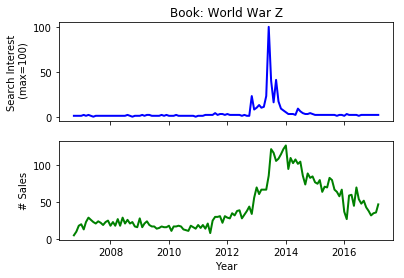

<Figure size 432x288 with 0 Axes>

In [9]:
############ SHOW THE INPUT & OUTPUT TIMESERIES ##############
df_G, df_S, OptDict = Generate_DataFrames('WWZ',12)
plot_df(df_G,df_S,OptDict)

# Let's plot a few years of data
f = plt.figure()
# ax = autocorrelation_plot(df_S.Checkouts)

**Figure 1** _Top panel (blue) is the monthly Search Volume for the book over several years, indexed to max=100.  Bottom panel (green) is the monthly Rentals for the book over the same time period._

Important features to note are the sharp spike in interest, coinciding with a large jump in book sales, and the continuing fat tail of sales after the interest spike (during a period where there is little search interest). Thus there is a strong causative relationship, but poor correlation, between our input and output.

Next, we apply the lagged linear model to this dataset:

In [7]:
######### INTERACTIVE ML WINDOW ##########
def interactML_Wrapper(n_months,F_str):
    df_G, df_S, OptDict     = Generate_DataFrames(F_str,n_months)
    Lag_Lin_Model,y_predict = Do_LagLinModel(df_G,df_S,OptDict)
    # plot
    plot_LagLinModel_2panel(df_G,df_S,y_predict,OptDict)
    return
    
interact(interactML_Wrapper, n_months=widgets.IntSlider(min=1,max=30,step=1,value=6),
         F_str=['WWZ','HP','HG','NotW','DoF','1984','Bible','HG03']);
interact(interactML_Wrapper, n_months=widgets.IntSlider(min=1,max=30,step=1,value=14),
         F_str=['WWZ','HP','HG','NotW','DoF','1984','Bible','HG03']);

interactive(children=(IntSlider(value=6, description='n_months', max=30, min=1), Dropdown(description='F_str',…

interactive(children=(IntSlider(value=14, description='n_months', max=30, min=1), Dropdown(description='F_str'…

**Figures 2,3** _Lagged Linear machine learning model (using parameters set in options and listed in plot title).  Model is applied to the blue data and generates the dashed blue line overlaid over the green data in the lower panel_

Figs 2,3 are illustrative of the general result from the lagged linear model: an overfit of the data within the window period, and a poor fit outside of it.

Before we judge lagged linear models, let us see what the kernel convolution method can do:

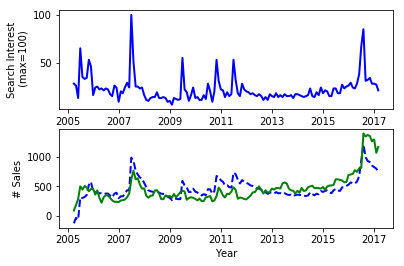

In [95]:
############ DIRECT FITTING OF MY MODEL ##############
df_G, df_S, OptDict = Generate_DataFrames('HP',0)
JB_params = Do_JBmodel(df_G,df_S)
plot_JBmodel(df_G,df_S,JB_params)

**Figure 4** _Kernel Convolution Model.  Model is applied to the blue data and generates the dashed blue line overlaid over the green data in the lower panel_

Fig 4 shows a smooth fit that tracks the output data with reasonable consistency throughout the time period, and makes a sensible future prediction of sales.

Full exploration of the available data shows this to be a consistent trend. Lagged linear models have regions of overfit interspaced with poor fits, and their forecasts are poor.  Kernel Convolution gives a relatively smooth fit of constant accuracy.

Having covered accuracy, let's look at the speed of these methods:

In [26]:
######### DO TIMING TESTS ##########
df_G, df_S, OptDict = Generate_DataFrames('HG03',0)

In [29]:
%%timeit -n3
TimingJB_Wrapper(df_G,df_S)

20.9 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [30]:
%%timeit -n3
TimingML_Wrapper(50,'HG03')

297 ms ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


For the current example, Kernel convolution takes about 20~ms and lagged linear models take about 280~ms. A huge speed advantage for Kernel convolution.

In [ ]:
######### FIXED ML WINDOWS ##########
#### Do an ML model run & plot
# Setup
n_months_window = 12
df_G, df_S, OptDict     = Generate_DataFrames('WWZ',n_months_window)
Lag_Lin_Model,y_predict = Do_LagLinModel(df_G,df_S,OptDict)
# plot
plot_LagLinModel_2panel(df_G,df_S,y_predict,OptDict)


# Setup
n_months_window = 18
df_G, df_S, OptDict     = Generate_DataFrames('WWZ',n_months_window)
Lag_Lin_Model,y_predict = Do_LagLinModel(df_G,df_S,OptDict)
# plot
plot_LagLinModel_2panel(df_G,df_S,y_predict,OptDict)


In [ ]:
#### Show kernel
df_G, df_S, OptDict     = Generate_DataFrames('HG',n_months_window)
Lag_Lin_Model,y_predict = Do_LagLinModel(df_G,df_S,OptDict)
plot_LagLinKernel(Lag_Lin_Model, OptDict)

GK = JB_Kernel(df_G.SearchVol,*JB_params)
plt.figure()
plt.plot(df_G.Month[1:], GK)

GUIDE: Blue shows actual book rental numbers. Other colors show the forecast from Google search data applied in a forward-chain testing routine, with GREEN being the lagged linear model and RED the kernel convolution model
INDICES -- TRAIN: 0:31 TEST: 32:59
   ML SCORE: -6.661
   KC SCORE: 0.017


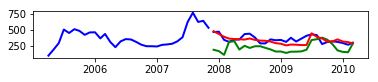

********************
INDICES -- TRAIN: 0:59 TEST: 60:87
   ML SCORE: -0.007
   KC SCORE: 0.148


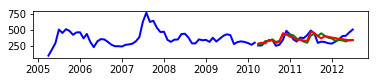

********************
INDICES -- TRAIN: 0:87 TEST: 88:115
   ML SCORE: -10.445
   KC SCORE: -4.682


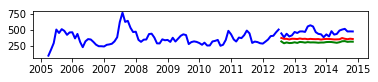

********************
INDICES -- TRAIN: 0:115 TEST: 116:143
   ML SCORE: -1.202
   KC SCORE: 0.469


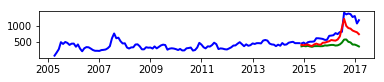

********************


In [106]:
############ EXAMPLE OF A TIME-SERIES FITTING METHOD ############
# from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
from sklearn.metrics import r2_score

### Define data
# inits
n_month_window = 12
Book_string    = 'HP' 
N_SPLIT = 4
# generator function
df_G, df_S, OptDict = Generate_DataFrames(Book_string,n_month_window)

### Extract the X,y in classic ML parlence
X = df_G.loc[:, df_G.columns != 'Month']
y = df_S.Checkouts
dates = df_S.Month
tscv = TimeSeriesSplit(n_splits=N_SPLIT)

### Loop across the forward chain
# inits for plotting
pyplot.figure()
index = 1
# loop
print(f'GUIDE: Blue shows actual book rental numbers. Other colors show the forecast from Google search data applied in a forward-chain testing routine, with GREEN being the lagged linear model and RED the kernel convolution model')
for train_index, test_index in tscv.split(X):
    ## Cuts
    print(f'INDICES -- TRAIN: {min(train_index)}:{max(train_index)} TEST: {min(test_index)}:{max(test_index)}')
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    ## ML MODEL -- fit and validation
    Lag_Lin_Model = Train_LagLinModel(X_train,y_train)
    y_preds       = Lag_Lin_Model.predict(X_test)
    print(f'   ML SCORE: {Lag_Lin_Model.score(X_test,y_test):.3f}')
    
    ## JB model fit and prediction
    JB_y_preds = ForwardChain_JBModel(X,y,train_index,test_index)
    print(f'   KC SCORE: {r2_score(y_test, JB_y_preds):.3f}')
    
    ## plot?
    pyplot.subplot(100*N_SPLIT+10 + index)
    pyplot.plot(dates[train_index], y_train, 'b', dates[test_index],y_test, 'b',
                dates[test_index],y_preds, 'g',dates[test_index],JB_y_preds,'r')
#     pyplot.plot([None for i in y_train] + [x for x in y_test])
    pyplot.show()
    print('********************')
    index += 1
    




## FUNCTION STORAGE

### Below are the function definitions that can be called for simple interactive plotting

###### 1) Gets everything needed for analysis, setting up dataframes compatible with my model and the ML method

In [2]:
##### DEFINE THE IMPORT DATASET
MyOption = 'HG'

def Generate_OptionsDict(MyOption,n_months_window):
    '''#### Depending on item chosen, setup a dictionary listing the appropriate files and filter.
    INPUT:  MyOption = string reference to a particular book in the test dataset eg. 'WWZ'
            n_months_window = max number of months to offset the search data timeseries by eg. 12 means add twelve lagged datasets from 1-to-12 months of offset
            
    OUTPUT: OptDict = Dictionary containing the relevant options and filters to understand/generate the two dataframes we generate for the requested book.
    '''
    
    OptDict = dict()
    OptDict['n_month_window'] = n_months_window
    OptDict['Search_file'] = './DATA/SeattleSearch_'+MyOption+'.csv'
    OptDict['Books_file']  = './DATA/Checkouts_'+MyOption+'.csv'
    if MyOption is 'WWZ':
        ## WWZ
        OptDict['Filter_Str']  = "World War Z"
    elif MyOption is 'HG':
        ## HUNGER GAMES
        OptDict['Filter_Str']  = "Hunger Games"
    elif MyOption is 'NotW':
        ## Name of the Wind
        OptDict['Filter_Str']  = "Name of the Wind"
    elif MyOption is 'DoF':
        ## In defense of Food
        OptDict['Filter_Str']  = "In Defense of Food"
    elif MyOption is 'Bible':
        ## In defense of Food
        OptDict['Filter_Str']  = "Bible"
    elif MyOption is '1984':
        ## In defense of Food
        OptDict['Filter_Str']  = "Nineteen eighty-four"
    elif MyOption is 'HP':
        ## In defense of Food
        OptDict['Filter_Str']  = "Harry Potter"
    elif MyOption is 'HG03':
        ## HUNGER GAMES extended
        OptDict['Filter_Str']  = "Hunger Games"
    return OptDict

def Generate_DataFrames(MyOption,n_months_window):
    '''#### Depending on item chosen, generate dataframes and dictionary of model options.
    INPUT:  MyOption = string reference to a particular book in the test dataset eg. 'WWZ'
            n_months_window = max number of months to offset the search data timeseries by eg. 12 means add twelve lagged datasets from 1-to-12 months of offset
            
    OUTPUT: df_G, df_S = Panda dataframes containing, respectively, the Google-search-volume and the Seattle-rental-data.
            OptDict    = Dictionary containing the relevant options and filters to understand these two dataframes
    '''
    #### Depending on item chosen, setup a dictionary listing the appropriate files and filter
    OptDict = Generate_OptionsDict(MyOption,n_months_window)
    # for legibility, write optDict to variables for use inside this function
    Search_file = OptDict['Search_file'] 
    Books_file  = OptDict['Books_file']
    Filter_Str  = OptDict['Filter_Str']

    
    ##### Import SEARCH data eg. WWZ #####
    ## Google trends
    df_G = pd.read_csv(Search_file)
    df_G.Month = pd.to_datetime(df_G['Month'], format='%Y-%m')

    ##### Insert Lagged timeseries into the dataframe -- Needed to the ML reference Soln. Not needed for JB Model.
    for i in range(1,n_months_window+1,1):
        exec("df_G['SV_"+str(i)+ "']=df_G['SearchVol'].shift("+str(i)+")")
    # convert NaN from lagging to zero (ML freaks out on NaN)
    df_G = df_G.fillna(0);



    ##### Import Seattle library data #####
    ##### LOAD
    df2 = pd.read_csv(Books_file,encoding = "ISO-8859-1") #fancy encoding to ensure we can read all text
#     df2.head()

    ##### CLEAN
    #### Manipulate & clean
    #** filter to useful types only
    df2 = df2[df2['MaterialType'].isin(['BOOK','EBOOK','AUDIOBOOK'])]
    #** Filter by 'title contains', correcting alternate caps
    df2 = df2[df2['Title'].str.contains(Filter_Str, case=False)]
    #** force numeric
    # col_list = ['CheckoutMonth','CheckoutYear','Checkouts']
    col_list = ['Checkouts']
    df2[col_list] = df2[col_list].apply(pd.to_numeric)
    # Create year-month and convert into suitable date object
    df2['YearMon'] = df2['CheckoutYear'].astype(str) +'-'+ df2['CheckoutMonth'].astype(str)
    df2.YearMon    = pd.to_datetime(df2['YearMon'], format='%Y-%m')

    ##### MODIFY -- cache by total checkouts per month
    # ## Option 1: creat col of uniques and then do sapply-like operations (lambdas perhaps?)
    # dfa = pd.DataFrame(df2.YearMon.unique())
    # df.apply(lambda x: x['a'] in x['b'], axis=1)
    ## Option 2: use a groupby
    df_S = pd.DataFrame(df2.groupby(['YearMon'])['Checkouts'].sum())
    df_S['Month'] = pd.to_datetime(df_S.index.values, format='%Y-%m')
    df_S.head()
    
    ### clean variables
    del df2
    del Search_file,Books_file,Filter_Str,n_months_window
    
    return df_G, df_S, OptDict


def plot_df(df_G,df_S,OptDict):
    
    ############ SHOW THE INPUT & OUTPUT TIMESERIES ##############
#     plt.figure(1)
#     plt.subplot(211)
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(df_G.Month, df_G.SearchVol, 'b',linewidth=2.0,label='hi!')
    ax1.set(ylabel="Search Interest\n (max=100)")
    ax1.set_title('Book: ' + OptDict['Filter_Str'])
#     plt.subplot(212)
    ax2.plot(df_G.Month,df_S.Checkouts,color='g',linewidth=2.0)
    plt.xlabel("Year")
    plt.ylabel("# Sales")
    plt.show;

###### 2) the Machine Learning Model applied to a particular dataset, and plots thereof.

In [36]:
def Do_LagLinModel(df_G,df_S,OptDict):
    '''
    Takes input dataframes df_G,df_S and then fits them with a lagged linear model.
    Returns the model, and the y_prediction of that model.
    '''
    ### Set up pipeline for a lagged ML set
    ### Initialise Data df.loc[:, df.columns != 'b']
    X = df_G.loc[:, df_G.columns != 'Month']
    y = df_S.Checkouts

    #### Get best fit
    Lag_Lin_Model = Train_LagLinModel(X,y)
    y_predict     = Lag_Lin_Model.predict(X)
    
    return Lag_Lin_Model,y_predict

def Train_LagLinModel(X,y):
    '''
    Takes X,y and then fits them with a lagged linear model.
    Returns the model.
    '''
    #### Get best fit
    Lag_Lin_Model = Ridge(alpha=201)
    Lag_Lin_Model.fit(X,y)
    
    return Lag_Lin_Model



def plot_LagLinModel_2panel(df_G,df_S,y_predict,OptDict):
###### The sharex methods leads to a flickering when using ipy widgets.  do not use    
#     plt.figure()
#     f1, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
#     ax1.plot(df_G.Month, df_G.SearchVol, 'b',linewidth=2.0,label='hi!')
#     ax1.set(ylabel="Search Interest\n (max=100)")
#     ax1.set_title(OptDict['Filter_Str']+' | '+ str(OptDict['n_month_window'])+' month window')
# #     plt.subplot(212)
#     ax2.plot(df_G.Month,df_S.Checkouts,color='g',linewidth=2.0)
#     plt.xlabel("Year")
#     plt.ylabel("# Sales")
#     plt.show;
    
    
    plt.figure()
    plt.subplot(211)
    p1 = plt.plot(df_G.Month, df_G.SearchVol, 'b',linewidth=2.0,label='hi!')
    plt.ylabel("Search Interest\n (max=100)")
    plt.title(OptDict['Filter_Str']+' | '+ str(OptDict['n_month_window'])+' month window')
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])

    plt.subplot(212)
    plt.plot(df_G.Month,y_predict,'b--',linewidth=2.0, label='hi!')
    plt.plot(df_G.Month,df_S.Checkouts,color='g',linewidth=2.0);
    plt.xlabel("Year")
    plt.ylabel("# Sales")
    plt.show;

def plot_LagLinModel_1panel(df_G,df_S,y_predict,OptDict):
    ### Big square plot
    fig, axis1 = plt.subplots()
    axis1.plot(df_G.Month,df_S.Checkouts,'g')
    axis2 = axis1.twinx() 
    axis2.plot(df_G.Month,y_predict,'b--')
    axis1.set_xlabel("Months")
    axis1.set_ylabel("# Checkouts")
    axis1.set_title(OptDict['Filter_Str'])
    plt.show

def plot_LagLinKernel(Lag_Lin_Model,OptDict):
    plt.figure()
    plt.plot(Lag_Lin_Model.coef_)
    plt.xlabel("Months")
    plt.ylabel("Relative influence")
    plt.title('Kernel: '+OptDict['Filter_Str']+' | '+ str(OptDict['n_month_window'])+' month window')   

###### 3) My model functions [used in combination with curve-fit]

In [4]:
from SeattleBooks_KernelConvolutionFunctions import ConvDisc, JB_Kernel, JB_Model

###### 4) The curve fit of my model, nicely packaged into a function


In [105]:
############ DIRECT FITTING OF MY KERNEL ##############
def Do_JBmodel(df_G,df_S):
    '''Extract info from Dataframes and perform fit'''
    ### Get Data
    input_data        = df_G.SearchVol
    outputData_2match = df_S.Checkouts

    ## Do fit
    JB_params = Fit_JBmodel(input_data, outputData_2match)
    return JB_params

def Fit_JBmodel(input_data, outputData_2match):
    '''peform model fit on the input and output data'''
    ## Do fit
    JB_params, pcov = curve_fit(JB_Model, input_data, outputData_2match,
                                bounds=((-np.inf, -np.inf, -np.inf, 1.0), (np.inf, 0, np.inf, 102.5)))
    return JB_params

def ForwardChain_JBModel (X,y,train_index,test_index):
    test_train_index = np.concatenate((train_index,test_index))
    SearchVol = X.iloc[test_train_index,0]
    Books     = y[test_train_index]
    JB_params = Fit_JBmodel(SearchVol, Books)
    JB_y_preds= JB_Model(df_G.SearchVol.iloc[test_train_index], *JB_params)[test_index]
    return JB_y_preds


def plot_JBmodel(df_G,df_S,JB_params):
    plt.figure(1)
    plt.subplot(211)
    p1 = plt.plot(df_G.Month, df_G.SearchVol, 'b',linewidth=2.0,label='hi!')
    plt.ylabel("Search Interest\n (max=100)")

    plt.subplot(212)
    plt.plot(df_G.Month, JB_Model(df_G.SearchVol, *JB_params), 'b--',linewidth=2.0, label='hi!')
    plt.plot(df_G.Month,df_S.Checkouts,color='g',linewidth=2.0);
    plt.xlabel("Year")
    plt.ylabel("# Sales")
    plt.show;
    

def plot_JBkernel(df_G,JB_params):
    ### Fetch Kernel
    GK = JB_Kernel(df_G.SearchVol,*JB_params)
    
    ### Plot Kernel
    secPerYr = np.pi
    plt.figure()
    plt.plot((df_G.Month[0:len(GK)] - df_G.Month[0]).dt.days,GK/max(GK) ,color='k',linewidth=2.0);
    plt.xlabel("Days")
    plt.ylabel("Relative importance")
    plt.show;
    

###### 5) Wrappers to facilitate timing functions

In [6]:
######## TIMING FUNCTIONS ##########
def TimingJB_Wrapper(df_G,df_S):
#     df_G, df_S, OptDict = Generate_DataFrames(F_str,0)
    JB_params = Do_JBmodel(df_G,df_S)
def TimingML_Wrapper(n_months,F_str):
    df_G, df_S, OptDict     = Generate_DataFrames(F_str,n_months)
    Lag_Lin_Model,y_predict = Do_LagLinModel(df_G,df_S,OptDict)

## Ongoing production

.

.

.

.

### Current Check and plots

In [12]:
GK = JB_Kernel(df_G.SearchVol,*JB_params)
i=10

print(np.where(GK<= (max(GK)/i))[0][0])
print(np.argmax(GK<= (max(GK)/i)))
print(f'min(GK) = {min(GK)}')
print(f'max(GK)/{i} = {(max(GK)/i)}')

9
9
min(GK) = 0.10229394434736287
max(GK)/10 = 0.5178294444160213


5.178294444160213 -1.0250060375426584 78.4799479482064 51.75


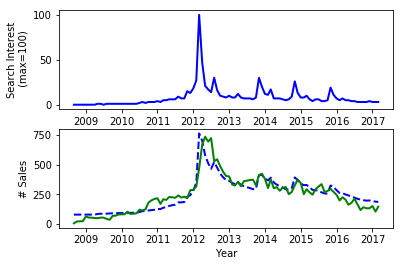

In [31]:
############ DIRECT FITTING OF MY MODEL ##############
df_G, df_S, OptDict = Generate_DataFrames('HG',0)
JB_params = Do_JBmodel(df_G,df_S)
plot_JBmodel(df_G,df_S,JB_params)
print(*JB_params)
# plot_JBkernel(df_G,JB_params)

In [10]:
(df_G.Month - df_G.Month[0]).dt.days.head(5)

0      0
1     30
2     61
3     91
4    122
Name: Month, dtype: int64

### TESTING FEATURES (Old)

In [6]:
# ######## np convolve test 
# # (conclusion: np.convolve(a, b, mode='full') gives us the desired moving window behaviour where b is the kernel)
# a= np.array([0.,1.,2.,3.,4.,20.,4.,3.,2.,1.,0.])
# # a= np.ones(8)
# b= np.ones(4)
# c = np.true_divide(np.array([4.,3.,2.,1.]),4)
# b=c
# nx = len(a)
# nk = len(b)
# Y1 = np.zeros(nk+nx)

# print(a)
# print(b)
# Y0 = np.convolve(a, b, mode='full')
# Y0 = Y0[0:len(Y0)-nk+1]
# print(Y0)

# for i in range(len(a)):
#     Y1[i:(i+nk)]+= b*a[i]
# # Trim
# idx = np.argmax(Y1<= (max(Y1)/10000)) # cut at threshold.  if no match, returns 0
# print(f'idx: {idx}')
# if idx == 0:
#     idx = nx # same length as input    
# print(f'idx: {idx}')
# Y1 = Y1[0:(nx)]
# print(Y1)

In [ ]:
# ###### AUTOCORRELATION could bring out some important features
# ### source: https://201809.tditrain.com/user/jmaburley@gmail.com/notebooks/datacourse/viz/VZ_Exploratory_Visualization.ipynb
# from pandas.plotting import autocorrelation_plot, lag_plot
# # autocorrelation  example
# autocorrelation_plot(goog_open)
# matplotlib.pyplot.xlabel('Lag (days)')

In [ ]:
# ################ Training using GridSearchCV ################
# ### Set the parameters by cross-validation
# ## random split into test & training
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)
# ## Set the parameters by cross-validation
# tuned_parameters = [{'alpha': list(range(1,2001,10))}]
# GSCV = GridSearchCV(Lag_Lin_Model, tuned_parameters, cv=5,n_jobs=-1)
# GSCV.fit(X, y)
# GSCV.cv_results_['mean_train_score']
# pprint(GSCV.best_params_)

# #### Test with plot
# # x_4plot = [d['alpha'] for d in GSCV.cv_results_['params']]
# # y_4plot = GSCV.cv_results_['mean_test_score']
# # plt.plot(x_4plot,y_4plot)
# # plt.ylabel('mean_test_score')
# # plt.xlabel('Ridge Alpha')

In [321]:
# ######### INTERACTIVE WINDOW ##########
# def interactJB_Wrapper(b):
#     model_params = np.array([JB_params[0],b,JB_params[2]])
#     plot_JBmodel(df_G,df_S,model_params)
# interact(interactJB_Wrapper, b=(-1,-0.1,.1));

In [311]:
# Y = np.ones(5)
# GK = np.multiply(np.ones(2),6)

# # Out = ConvDisc(GK,Y,0)
# # print(Out)

# Out = JB_Model(Y,1.,-1.,10.,1)
# print(Out)


[0.         1.         0.5        0.33333333 0.25      ]
[10.         11.         11.5        11.83333333 12.08333333]


array([ 6.17580785, -1.17788179, 80.54447545])


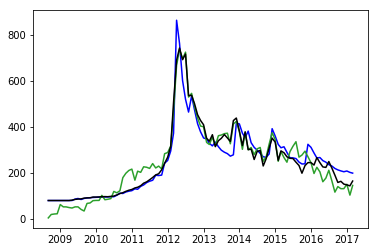

5.411466359064312
-1.065054248080244
74.11883217038863


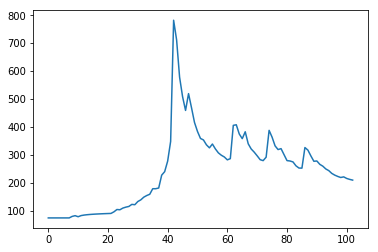

In [300]:
# out = JB_Model(input_data, *popt)
# plt.plot(out)

In [54]:
### Working out how to filter in Pandas
# df.filter(items='Title',like='World').head()
## contains literal match
# df2[df2['MaterialType'] == 'BOOK'].head()
# df3 = df2[df2['MaterialType'].isin(['BOOK','EBOOK','AUDIOBOOK'])]
# df3.head()
## contains match to a string
# df2[df2['Title'].str.contains("world", case=False)].head()

In [53]:
# dfa = pd.DataFrame(df2.YearMon.unique())
# dfa.head()

,0
0,2015-02-01
1,2015-03-01
2,2015-04-01
3,2015-05-01
4,2015-06-01


In [70]:
###### ML CLASS INITS ######
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        # What needs to be done here?
        self.est = estimator
    
    def fit(self, Xs, ys):
        # Fit the stored estimator.
        # Question: what should be returned?
        self.est.fit(Xs, ys)
        return self
    
    def transform(self, Xs):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        pred_vec = self.est.predict(Xs)
#         print(type(pred_vec))
        y_preds = np.array(pred_vec).reshape(-1, 1)
#         print(type(y_preds))
#         print('\n')
        return y_preds

DatetimeIndex(['2006-10-01', '2006-11-01', '2006-12-01', '2007-01-01',
               '2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01',
               ...
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01'],
              dtype='datetime64[ns]', name='YearMon', length=126, freq=None)

### Next Section

# Intro
This is a working notebook to try and collect my method into a fully python implementation.

Current needs are:
   * Machine Learning prediction
   * Best Fit of an arbitrary input function
   * timing and accuracy comparison of the two methods
   
Good-to-have:
* Fully automated selection of book title generating my suite of plots in Search vol, rentals and prediction
    
Further notes:
 * Autocorrelation would be interesting eg in VZ_Exploratory_Visualisation
 '''# autocorrelation is near 1 for short lags
autocorrelation_plot(goog_open)
matplotlib.pyplot.xlabel('Lag (days)')'''

* Need to plot JB kernel more easily